In [48]:
import os
import pickle
from matplotlib import rcParams
import matplotlib.pyplot as plt
from utils.utils import *
from utils.data_processing import *
import logging as log
from logger.logger import setup_logging
from utils.preprocessing import Shaper

In [230]:
# set all values from the config
config = read_json("./config/generate_data.json")
dT = config["dT"]

x_scale = config["x_scale"]
y_scale = config["y_scale"]

# used as info file for the folder where the data is created
info = dict()
info["createdOn"] = datetime.now().strftime("%Y%m%dT%H%M")
load_folder_raw = "./data/raw/"
load_folder_original = "./data/original/"

######################################################
#                     LOAD DATA                      #
######################################################
# external information (demographic and weather)
# not these are only weather values for 2014
weather_df = pd.read_pickle(load_folder_raw + "weather_minmax_normed.pkl")
weather_df.index = weather_df.date  # set datetime index todo: move to data-processing
weather_df.drop(columns="date", inplace=True)  # drop the time column
extra_day = weather_df.iloc[-1]
extra_day.name = extra_day.name + pd.DateOffset(1)
weather_df = weather_df.append(extra_day)
# re-sample weather data
is_gte_24hours = 'D' in dT or dT == '24H'
if is_gte_24hours:
    weather_df = weather_df.resample(dT).mean()
else:
    weather_df = weather_df.resample(dT).pad()
weather_df = weather_df.iloc[:-1]
weather_vectors = weather_df.values

# physical coords and their tracts
valid_points = np.load(load_folder_raw + "valid_points.npy")
valid_tracts = np.load(load_folder_raw + "valid_tracts.npy")
invalid_tracts = np.load(load_folder_raw + "invalid_tracts.npy")
tract2points = pd.read_pickle(load_folder_raw + "tract2points.pkl")
point2tract = pd.read_pickle(load_folder_raw + "point2tract.pkl")
tract_boundaries = pd.read_pickle(load_folder_raw + "tract_boundaries.pkl")
tract2km2 = pd.read_pickle(load_folder_raw + "tract2km2.pkl")

# link between points and demographic data
point2spatial_info = pd.read_pickle(load_folder_raw + "point2spatial_info.pkl")  # todo is this normalised?

######################################################
#                PREPROCESS DATA                     #
######################################################
# Time dimensions
info["dT"] = dT
# Spatial dimensions

# [20,16] - [10,8] - [5,4] - [3,2] - [1,1]
xy_scale = np.array([x_scale, y_scale])  # must be integer so that we can easily sample demographic data
dx, dy = xy_scale * np.array([0.001, 0.001])
info["dx"] = float(dx)
info["dy"] = float(dy)
info["x in metres"] = 85000 * float(dx)
info["y in metres"] = 110000 * float(dy)

log.info("Cell sizes: %.3f m in x direction and %.3f m in y direction" % (85000 * dx, 110000 * dy))

crimes = pd.read_pickle(load_folder_raw + "crimes_2012_to_2018.pkl")

# CHOOSE CRIME TYPES
valid_crime_types = [
    "THEFT",
    "BATTERY",
    "CRIMINAL DAMAGE",
    "NARCOTICS",
    "ASSAULT",
    "BURGLARY",
    "MOTOR VEHICLE THEFT",
    "ROBBERY",
]
# filter useless crime types
crimes = crimes[crimes["Primary Type"].isin(valid_crime_types)]

# take out western most tract to simplify things for the cnn
crimes = crimes[crimes.tract != 7706.02]

2019-10-26T14:14:42 | root | INFO | Cell sizes: 85.000 m in x direction and 110.000 m in y direction


In [192]:
np.unique(crimes.tract.values).shape


(419,)

In [194]:
chic = pd.read_csv("./data/original/Crimes_Chicago_2001_to_2019.csv")

In [202]:
chic['Census Tracts'].nunique()

801

In [170]:
len(set(point2tract.values()))

790

In [275]:
crimes = pd.read_pickle(load_folder_raw + "crimes_2012_to_2018.pkl")

In [276]:
dx = 0.001
dy = 0.001

crimes['X'] = crimes.Longitude
crimes['Y'] = crimes.Latitude

crimes.X = np.round(crimes.X/dx)*dx
crimes.Y = np.round(crimes.Y/dy)*dy


crimes.X = crimes.X.round(decimals=3) # made to still be hashable
crimes.Y = crimes.Y.round(decimals=3)

# crimes = crimes[(crimes.Y <= x_max) & (crimes.X >= x_min) & (crimes.Y <= y_max) & (crimes.Y >= y_min)]

######

#
# drop all crimes that aren't valid points and add tract to the rest of the crimes
err = []
tracts = []
for i in range(len(crimes)):
    point = (crimes.X.iloc[i], crimes.Y.iloc[i])
    try:
        tr = point2tract[point]
        tracts.append(tr)
    except KeyError:
        err.append(i)

err = np.array(err)
crimes.drop(index=crimes.iloc[err].index, inplace=True)
crimes['tract'] = tracts

In [277]:
# [20,16] - [10,8] - [5,4] - [3,2] - [1,1]
x_scale, y_scale = 10,8


xy_scale = np.array([x_scale, y_scale])  # must be integer so that we can easily sample demographic data
dx, dy = xy_scale * np.array([0.001, 0.001])
info["dx"] = float(dx)
info["dy"] = float(dy)
info["x in metres"] = 85000 * float(dx)
info["y in metres"] = 110000 * float(dy)

log.info("Cell sizes: %.3f m in x direction and %.3f m in y direction" % (85000 * dx, 110000 * dy))

# crimes = pd.read_pickle(load_folder_raw + "crimes_2012_to_2018.pkl")

# CHOOSE CRIME TYPES
valid_crime_types = [
    "THEFT",
    "BATTERY",
    "CRIMINAL DAMAGE",
    "NARCOTICS",
    "ASSAULT",
    "BURGLARY",
    "MOTOR VEHICLE THEFT",
    "ROBBERY",
]
# filter useless crime types
crimes = crimes[crimes["Primary Type"].isin(valid_crime_types)]

# take out western most tract to simplify things for the cnn
crimes = crimes[crimes.tract != 7706.02]

start_date = '2012-01-01'#config["start_date"]
end_date = '2019-01-01'#config["end_date"]
info["start_date"] = start_date
info["end_date"] = end_date

t_range = pd.date_range(start_date, end_date, freq=dT)
crimes = crimes[crimes.Date < t_range[-1]]  # choose only crimes which lie in the valid time range
crimes = crimes[crimes.Date >= t_range[0]]  # choose only crimes which lie in the valid time range
# crimes.Date = crimes.Date.dt.floor(dT) # DON"T ROUND,
# ONLY FLOOR, OTHERWISE THE WEATHER DATA DOESNT LINE UP PROPERLY.

t_min = pd.Series(crimes.Date.min()).astype(np.int64)[0]
dt = pd.Series(t_range[1] - t_range[0]).astype(np.int64)[0]

t = crimes.Date.astype(np.int64)
t = t - t_min
t = t // dt
crimes["t"] = t

x_max_valid, y_max_valid = valid_points.max(0)
x_min_valid, y_min_valid = valid_points.min(0)

# we know all crimes have defined demographics
# spatial discritization with step
crimes["X"] = crimes.Longitude
crimes["Y"] = crimes.Latitude

# round Long and Lat to nearest increment of dx and dy
# all spots are defined?

crimes.X = np.round(crimes.X / dx) * dx
crimes.Y = np.round(crimes.Y / dy) * dy

crimes.X = np.round(crimes.X, decimals=3)  # used to make sure we can still hash coords
crimes.Y = np.round(crimes.Y, decimals=3)  # rounding ensures floating point issues are dealt with

log.info(f"Number of total crimes: {len(crimes)}")
crimes = crimes[
    (crimes.X <= x_max_valid) & (crimes.X >= x_min_valid) & (crimes.Y >= y_min_valid) & (crimes.Y <= y_max_valid)]
log.info(f"Number of crimes in valid spatial range: {len(crimes)}")

# x_range = np.arange(crimes.X.min(),crimes.X.max()+dx,dx)
# .001 because that is our smallest element dx can be bigger
# y_range = np.arange(crimes.Y.min(),crimes.Y.max()+dy,dy)
x_min, x_max = crimes.X.min(), crimes.X.max()
y_min, y_max = crimes.Y.min(), crimes.Y.max()

# .001 because that is our smallest element dx can be bigger
x_range = np.arange(crimes.X.min(), np.round(crimes.X.max() + dx, decimals=3), dx)
y_range = np.arange(crimes.Y.min(), np.round(crimes.Y.max() + dy, decimals=3), dy)

x_range = x_range.round(decimals=3)  # used to make sure we can still hash coords
y_range = y_range.round(decimals=3)

# filter because of floating point issues
x_range = x_range[(x_range >= x_min) & (x_range <= x_max)]
y_range = y_range[(y_range >= y_min) & (y_range <= y_max)]

x_min, x_max = x_range[0], x_range[-1]
y_min, y_max = y_range[0], y_range[-1]

crimes["x"] = np.array(np.round((crimes.X - x_min) / dx), dtype=int)
crimes["y"] = np.array(np.round((crimes.Y - y_min) / dy), dtype=int)

# only take crimes that land on nodes that have demographic info
all_crime_spots = crimes[["X", "Y"]].values
crimes["xy"] = list(map(tuple, all_crime_spots))
valid_crime_spots = set2d(crimes[["X", "Y"]].values) - (set2d(crimes[["X", "Y"]].values) - set2d(valid_points))
drop_crime_spots = list(set2d(all_crime_spots) - valid_crime_spots)
valid_crime_spots = np.array(list(valid_crime_spots))

indices_to_drop = []

for i in range(len(drop_crime_spots)):
    log.info(f"dropped {i}")
    indices = crimes[crimes.xy == drop_crime_spots[i]].index
    crimes.drop(index=indices, inplace=True)

log.info(f"Number of crimes valid spatial range and on nodes with demographic info: {len(crimes)}")

X, Y = np.meshgrid(x_range, y_range)
# crimes["Primary Type"].value_counts()
t_size = len(t_range) - 1  # dates are an extra one - the range indicates start and end walls of each cell
x_size = len(x_range)  # x_range are the means of each cell
y_size = len(y_range)  # y_range are the means of each cell

log.info(f"t_size:\t{t_size}\nx_size:\t{x_size}\ny_size:\t{y_size}")

A = crimes[["t", "x", "y"]].values[:]

log.info(f"A.shape -> {A.shape}")
log.info(f"t_size, x_size, y_size -> {t_size}, {x_size}, {y_size}")
log.info(f"crimes.t.max(), crimes.x.max(), crimes.y.max() -> {crimes.t.max()}, {crimes.x.max()},{crimes.y.max()}")
log.info(f"t_range[-1] -> {t_range[-1]}")
log.info(f"t_range[0] -> {t_range[0]}")

info["t_size"] = t_size
info["x_size"] = x_size
info["y_size"] = y_size

info["crimes.t.max()"] = int(crimes.t.max())
info["crimes.t.min()"] = int(crimes.t.min())
info["crimes.x.max()"] = int(crimes.x.max())
info["crimes.x.min()"] = int(crimes.x.min())
info["crimes.y.max()"] = int(crimes.y.max())
info["crimes.y.min()"] = int(crimes.y.min())

crime_grids = make_grid(A, t_size, x_size, y_size)

######################################################
#          TRACTS GRIDS DATA GENERATION               #
######################################################
# Creates Grid where the cell value is the total crime in that tract for that time step
tract2index = {}
for i, tr in enumerate(valid_tracts):
    tract2index[tr] = i

trindex = []
for tr in crimes.tract.values:
    trindex.append(tract2index[tr])

crimes['trindex'] = trindex
tracts = np.zeros((t_size, len(valid_tracts)))  # crime count in tracts over time - can be used for lstm

tract_info = crimes[['t', 'trindex']].values

for t, tr in tract_info:
    tracts[t, tr] += 1

# make grid by the number of crimes in that tract
tract_count_grids = np.zeros_like(crime_grids)

# for x, y in valid_crime_spots:  # leads to some missing data
for x, y in valid_points:
    tr = point2tract[x, y]
    if x in x_range and y in y_range:
        x = np.argwhere(x_range == x)[0, 0]
        y = np.argwhere(y_range == y)[0, 0]
        info_ = tracts[:, tract2index[tr]]
        tract_count_grids[:, y_size - y - 1, x] = np.array(info_)

# Adding any crime related data to the channels, e.g. tract counts if we want to
tract_count_grids = np.expand_dims(tract_count_grids, axis=1)

2019-10-26T16:39:22 | root | INFO | Cell sizes: 850.000 m in x direction and 880.000 m in y direction
2019-10-26T16:39:22 | root | INFO | Number of total crimes: 1533179
2019-10-26T16:39:22 | root | INFO | Number of crimes in valid spatial range: 1530532
2019-10-26T16:39:30 | root | INFO | dropped 0
2019-10-26T16:39:30 | root | INFO | dropped 1
2019-10-26T16:39:30 | root | INFO | dropped 2
2019-10-26T16:39:30 | root | INFO | dropped 3
2019-10-26T16:39:31 | root | INFO | dropped 4
2019-10-26T16:39:31 | root | INFO | dropped 5
2019-10-26T16:39:31 | root | INFO | dropped 6
2019-10-26T16:39:32 | root | INFO | dropped 7
2019-10-26T16:39:32 | root | INFO | dropped 8
2019-10-26T16:39:32 | root | INFO | dropped 9
2019-10-26T16:39:32 | root | INFO | dropped 10
2019-10-26T16:39:33 | root | INFO | dropped 11
2019-10-26T16:39:33 | root | INFO | dropped 12
2019-10-26T16:39:33 | root | INFO | dropped 13
2019-10-26T16:39:34 | root | INFO | dropped 14
2019-10-26T16:39:34 | root | INFO | dropped 15
201

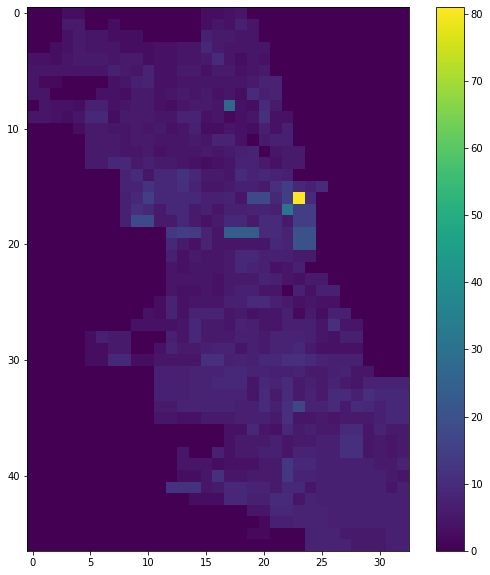

In [278]:
im(tract_count_grids.max(0)[0])

In [279]:
crimes = pd.to_pickleickleickleickleickleickle(crimes,load_folder_raw + "crimes_2012_to_2018_new.pkl")

In [117]:
tr = list(set(point2tract.values()))
c = [i for i in range(len(tr))]
tr2c = dict(zip(tr,c))

p = []
c = []
for k,v in point2tract.items():
    p.append(k)
    c.append(tr2c[v])  

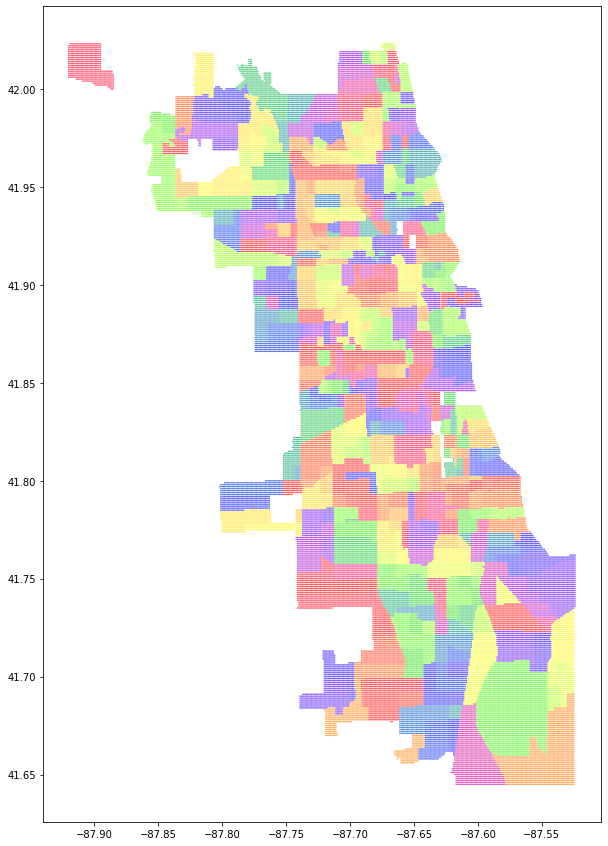

In [121]:
plt.figure(figsize=(10,15))
p = np.array(p)    
plt.scatter(p[:,0],p[:,1],s=.1,c=c,cmap='prism')    
plt.show()

In [236]:
crimes['tr_c'] = list(map(lambda x: tr2c[x], crimes.tract.values))

In [237]:
len(set(crimes.tr_c.values))

419

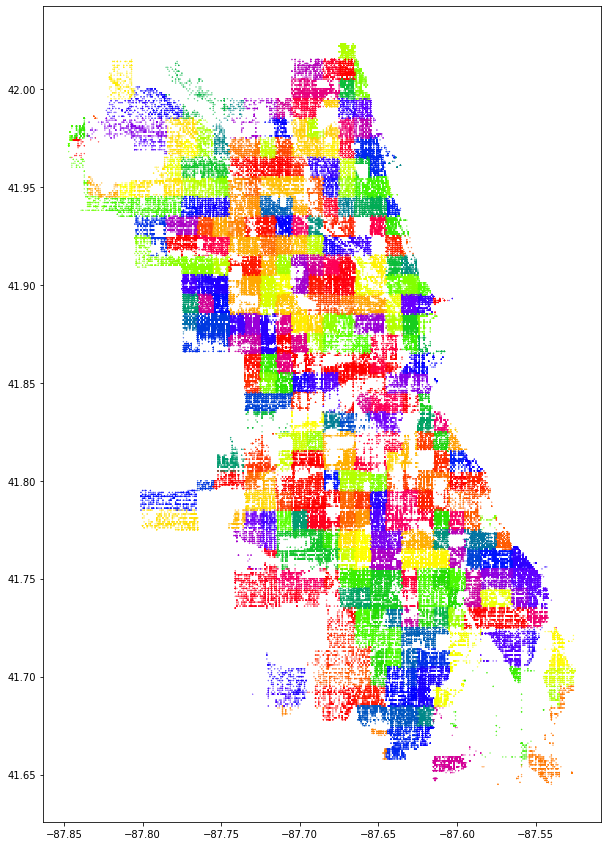

In [238]:
plt.figure(figsize=(10,15))
p = np.array(p)    
# plt.scatter(crimes.Longitude,crimes.Latitude,s=.1,c=crimes.tr_c,cmap='prism')    
plt.scatter(crimes.X,crimes.Y,s=.1,c=crimes.tr_c,cmap='prism')    
plt.show()

In [157]:
x_range = np.round(x_range, decimals=3)
y_range = np.round(y_range, decimals=3)

[[-87.617  41.645]
 [-87.616  41.645]
 [-87.615  41.645]
 ...
 [-87.668  42.023]
 [-87.667  42.023]
 [-87.666  42.023]]


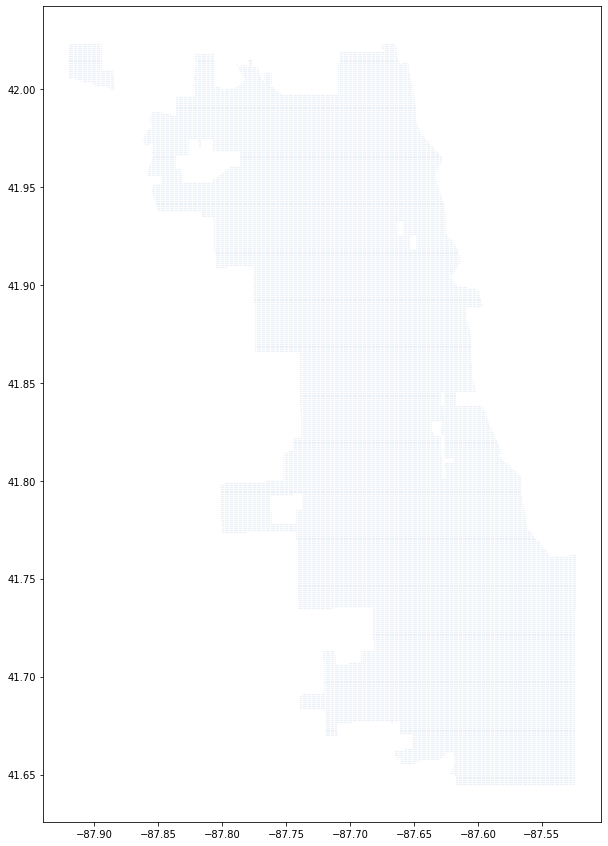

In [249]:
a = np.array(list(point2tract.keys()))
print(a)
plt.figure(figsize=(10,15))
plt.scatter(a[:,0],a[:,1],alpha=0.1,s=.1)
plt.show()

In [241]:
tract2index = dict(zip(valid_tracts, range(len(valid_tracts))))

trindex = []
for tr in crimes.tract.values:
    trindex.append(tract2index[tr])

crimes['trindex'] = trindex
tracts = np.zeros((t_size, len(valid_tracts)))  # crime count in tracts over time - can be used for lstm

tract_info = crimes[['t', 'trindex']].values

for t, tr in tract_info:
    tracts[t, tr] += 1

# make grid by the number of crimes in that tract
tract_count_grids = np.zeros_like(crime_grids)

# for x, y in valid_crime_spots:  # leads to some missing data
for x, y in valid_points:
    tr = point2tract[x, y]
    
    if x in x_range and y in y_range:
        x = np.argwhere(x_range == x)[0, 0]
        y = np.argwhere(y_range == y)[0, 0]
        info_ = tracts[:, tract2index[tr]]
        tract_count_grids[:, y_size - y - 1, x] =  np.array(info_)

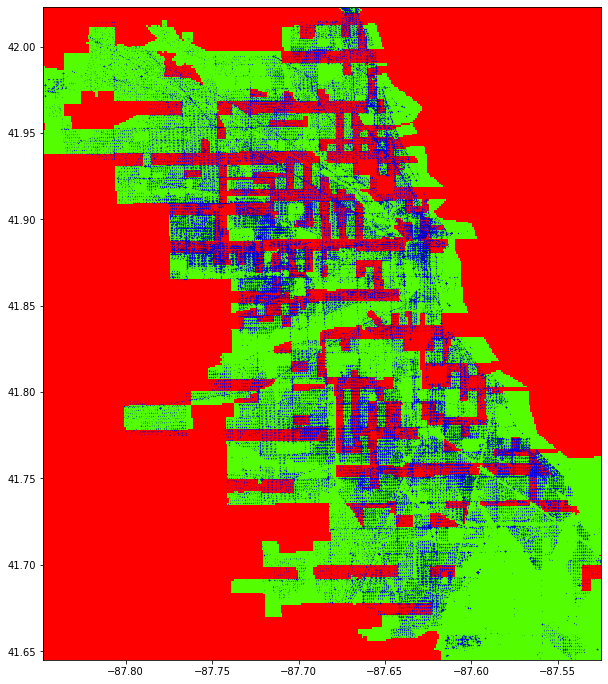

In [242]:
g = tract_count_grids.max(0)
g[g > 0] = 1

plt.figure(figsize=(10,15))
p = np.array(p)   
plt.imshow(g,extent=[x_range[0],x_range[-1],y_range[0],y_range[-1]],cmap='prism')
plt.scatter(crimes.Longitude,crimes.Latitude,s=.01,c='b',cmap='prism',alpha=.5)    
# plt.scatter(crimes.X,crimes.Y,s=.01,c='b',cmap='prism',alpha=.5)    
plt.show()

In [75]:
crimes

,ID,Date,Primary Type,Arrest,Latitude,Longitude,tract,t,X,Y,x,y,xy,trindex
1796537,9071327,2013-01-01 00:00:00,THEFT,False,41.736714,-87.600127,4401.02,0,-87.600,41.737,248,92,"(-87.6, 41.737)",449
1796543,9070149,2013-01-01 00:00:00,THEFT,False,41.743736,-87.702226,7005.02,0,-87.702,41.744,146,99,"(-87.702, 41.744)",632
1796550,9431960,2013-01-01 00:00:00,THEFT,False,41.930665,-87.715943,2207.02,0,-87.716,41.931,132,286,"(-87.716, 41.931)",251
1796528,9047162,2013-01-01 00:00:00,THEFT,True,41.895500,-87.765419,2513.00,0,-87.765,41.896,83,251,"(-87.765, 41.896)",319
1796504,9041745,2013-01-01 00:00:00,THEFT,False,41.789787,-87.665688,6704.00,0,-87.666,41.790,182,145,"(-87.666, 41.79)",592
1796552,8951454,2013-01-01 00:00:00,THEFT,False,41.902579,-87.669922,2421.00,0,-87.670,41.903,178,258,"(-87.67, 41.903)",294
1796508,9101785,2013-01-01 00:00:00,THEFT,False,41.775174,-87.671383,6706.00,0,-87.671,41.775,177,130,"(-87.671, 41.775)",594
1796516,8950831,2013-01-01 00:00:00,CRIMINAL DAMAGE,False,41.802421,-87.663591,6119.00,0,-87.664,41.802,184,157,"(-87.664, 41.802)",552
1796524,9046894,2013-01-01 00:00:00,THEFT,False,41.909396,-87.764017,2503.00,0,-87.764,41.909,84,264,"(-87.764, 41.909)",310
1796553,9233462,2013-01-01 00:00:00,THEFT,False,41.733453,-87.660564,7302.01,0,-87.661,41.733,187,88,"(-87.661, 41.733)",656


In [46]:
######################################################
#          DEMOGRAPHIC DATA GENERATION               #
######################################################
# todo implement interpolation for this as well.

num_demog_feats = 37
demog_grid = np.zeros((num_demog_feats, y_size, x_size))  # grids with demographic info

err = []
for x in range(x_size):
    for y in range(y_size):
        X_ = x_range[x]
        Y_ = y_range[y]
        try:
            demog_grid[:, y_size - y - 1, x] = np.array(
                point2spatial_info[X_, Y_])  # should be redone with filtered census data
        except KeyError:
            err.append((X_, Y_))

log.info(f"sum(demog_grid):\t {demog_grid.sum()}")
log.info(f"x_size*y_size:\t\t {x_size * y_size}")
log.info(f"len(err):\t\t {len(err)}")

# street view vectors
# some cells do not have coordinates
# we use pca to compress the feature vector (pca not necessarily needed)
# knn to fill in featureless cell with the values of the closest feature full cell
point2feats_res18 = pd.read_pickle(load_folder_raw + "point2feats_res18.pkl")

from sklearn.decomposition import PCA

coords = np.array(list(point2feats_res18.keys()))
feats = np.array(list(point2feats_res18.values()))

n_components = 512

pca = PCA(n_components=n_components)
c = pca.fit_transform(feats)
c = (c - c.min()) / (c.max() - c.min())

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=1, weights="uniform")
knn.fit(coords, c)
valid_feats = knn.predict(valid_points)

point2feats = dict()
for i, (x, y) in enumerate(valid_points):
    point2feats[x, y] = valid_feats[i]

street_grid = np.zeros((n_components, y_size, x_size))  # grids with demographic info
err = []
for x in range(x_size):
    for y in range(y_size):
        X_ = x_range[x]
        Y_ = y_range[y]
        try:
            street_grid[:, y_size - y - 1, x] = np.array(
                point2feats[X_, Y_])  # should be redone with filtered census data
        except KeyError:
            err.append((X_, Y_))

log.info(f"sum(street_grid):\t {street_grid.sum()}")
log.info(f"x_size*y_size:\t\t {x_size * y_size}")
log.info(f"len(err):\t\t {len(err)}")

#########################################################################
#                           CRIME TYPES GRID                            #
#########################################################################

c2i = {"THEFT": 0,
       "BATTERY": 1,
       "CRIMINAL DAMAGE": 2,
       "NARCOTICS": 3,
       "ASSAULT": 4,
       "BURGLARY": 5,
       "MOTOR VEHICLE THEFT": 6,
       "ROBBERY": 7}  



def type2index(crime_type):
    try:
        r = c2i[crime_type]
    except KeyError:
        r = 8  # all other types are translated to 8

    return r


crimes["c"] = crimes["Primary Type"].apply(type2index)

# FILTER BY CRIME TYPE
crimes = crimes[crimes.c < 8]

# ONE HOT ENCODING FOR THE CRIME TYPES
ohe = np.zeros((len(crimes), 8), dtype=int)
for i, c in enumerate(crimes.c):
    ohe[i, c] = 1

for i, k in enumerate(c2i):
    crimes[k] = ohe[:, i]

crimes["TOTAL"] = np.ones(len(crimes), dtype=int)

# INCLUDE ARRESTS
crimes["Arrest"] = crimes["Arrest"] * 1


crime_feature_indices = [
    "TOTAL",
    "THEFT",
    "BATTERY",
    "CRIMINAL DAMAGE",
    "NARCOTICS",
    "ASSAULT",
    "BURGLARY",
    "MOTOR VEHICLE THEFT",
    "ROBBERY",
    "Arrest"]

A = crimes[["t", "x", "y", "TOTAL", "THEFT", "BATTERY", "CRIMINAL DAMAGE", "NARCOTICS", "ASSAULT", "BURGLARY",
            "MOTOR VEHICLE THEFT", "ROBBERY", "Arrest"]].values


crime_type_grids = np.zeros((t_size, A.shape[-1] - 3, y_size, x_size))
# todo convert to sparse data matrices
for a in A:
    crime_type_grids[a[0], :, y_size - 1 - a[2], a[1]] += a[3:]

#########################################################################
#                            SAVE DATA                                  #
#########################################################################


# save figures
figsize = (8, 11)

v,c = np.unique(crime_grids.flatten(), return_counts=True)
c = 100*c/np.sum(c)
plt.figure(figsize=figsize)
plt.bar(v, c)
plt.yticks(np.arange(21)*5)
plt.title("Maximum Crimes per Time Step")
plt.ylabel("Frequency (%)")
plt.xlabel("Total Crimes per Time Step per Cell")
plt.grid(True)
plt.show()

plt.figure(figsize=figsize)
plt.scatter(X, Y, marker=".", label="range")
plt.scatter(valid_points[:, 0], valid_points[:, 1], marker=".", label="valid", s=1)
plt.scatter(crimes.X, crimes.Y, marker=".", label="round")
plt.legend(loc=3, prop={"size": 20})
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

plt.figure(figsize=figsize)
plt.title("Maximum Crimes per Time Step")
plt.imshow(crime_grids.max(0), cmap="viridis")
plt.colorbar()
plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.show()

plt.figure(figsize=figsize)
plt.title("Mean Crimes per Time Step")
plt.imshow(crime_grids.mean(0), cmap="viridis")
plt.colorbar()
plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.show()

plt.figure(figsize=figsize)
plt.title("Demographics Max Value")
plt.imshow(demog_grid.max(0), cmap="viridis")
plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.show()

plt.figure(figsize=figsize)
plt.title("Street View Data Max Value")
plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.imshow(street_grid.max(0), cmap="viridis")
plt.show()

#  ENSURE DIMS (N, C, H, W) FORMAT
crime_grids = np.expand_dims(crime_grids, axis=1)
demog_grid = np.expand_dims(demog_grid, axis=0)
street_grid = np.expand_dims(street_grid, axis=0)

NameError: name 'y_size' is not defined

### All we need is to ensure that our model evaluation output of all loaders are the same so that we could easily compare the models. Currenlty we do not have any proper models, this is quite the problem you see. 

### Should we iterate over the indexes - yes. We can compare the RNN and FNN - with the FNN. So many different things we wanted to plug.

In [280]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im

## Testing if data loaders are operational



In [281]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

from utils.configs import BaseConf
from utils.preprocessing import Shaper, MinMaxScaler, minmax_scale
from utils.utils import if_none

In [283]:
with np.load(data_path + "generated_data.npz") as zip_file:  # context helper ensures zip_file is closed
    for k, v in zip_file.items():
        log.info(f"\t{k} shape {np.shape(v)}")
    t_range = pd.read_pickle(data_path + "t_range.pkl")

    if conf.use_crime_types:
        crimes = zip_file["crime_types_grids"]
    else:
        crimes = zip_file["crime_grids"]

2019-10-26T19:45:14 | root | INFO | 	crime_feature_indices shape (10,)
2019-10-26T19:45:34 | root | INFO | 	crime_types_grids shape (730, 10, 376, 323)
2019-10-26T19:45:36 | root | INFO | 	crime_grids shape (730, 1, 376, 323)
2019-10-26T19:45:38 | root | INFO | 	tract_count_grids shape (730, 1, 376, 323)
2019-10-26T19:45:38 | root | INFO | 	demog_grid shape (1, 37, 376, 323)
2019-10-26T19:45:40 | root | INFO | 	street_grid shape (1, 512, 376, 323)
2019-10-26T19:45:40 | root | INFO | 	time_vectors shape (731, 52)
2019-10-26T19:45:40 | root | INFO | 	weather_vectors shape (365, 11)
2019-10-26T19:45:40 | root | INFO | 	x_range shape (323,)
2019-10-26T19:45:40 | root | INFO | 	y_range shape (376,)


(730, 1, 376, 323)

In [17]:
class FlatDataGroup:
    """
    FlatDataGroup class acts as a collection of datasets (training/validation/test)
    The data group loads data from disk, splits in separate sets and normalises according to train set.
    Crime count related data is first scaled using f(x) = log2(1 + x) and then scaled between 0 and 1.
    The data group class also handles reshaping of data.
    """

    def __init__(self, data_path: str, conf: BaseConf):
        """
        Args:
            data_path (string): Path to the data folder with all spatial and temporal data.
        """
        # [√] number of incidents of crime occurrence by sampling point in 2013 (1-D) :
        # [√] number of incidents of crime occurrence by census tract in 2013 (1-D) :
        # [√] number of incidents of crime occurrence by census tract yesterday (1-D) :
        # [√] number of incidents of crime occurrence by date in 2013 (1-D) : total_crimes

        with np.load(data_path + "generated_data.npz") as zip_file:  # context helper ensures zip_file is closed
            # print info on the read data
            log.info("Data shapes of files in generated_data.npz")
            for k, v in zip_file.items():
                log.info(f"\t{k} shape {np.shape(v)}")
            t_range = pd.read_pickle(data_path + "t_range.pkl")
            log.info(f"\tt_range shape {np.shape(t_range)}")

            if conf.use_crime_types:
                self.crimes = zip_file["crime_types_grids"]
            else:
                self.crimes = zip_file["crime_grids"]

            # fit crime data to shaper
            self.shaper = Shaper(data=self.crimes,
                                 threshold=conf.shaper_threshold,
                                 top_k=conf.shaper_top_k)

            # add tract count to crime grids - done separately in case we do not want crime types or arrests
            tract_count_grids = zip_file["tract_count_grids"]
            self.crimes = np.concatenate((self.crimes, tract_count_grids), axis=1)

            # squeeze all spatially related data
            # reshaped (N, C, H, W) -> (N, C, L)
            self.crimes = self.shaper.squeeze(self.crimes)

            # used for display purposes - and grouping similarly active cells together.
            self.sorted_indices = np.argsort(self.crimes[:, 0].sum(0))[::-1]

            # (reminder) ensure that the self.crimes are not scaled to -1,1 before
            self.targets = np.copy(self.crimes[1:, 0:1])  # only check for totals > 0
            self.targets[self.targets > 0] = 1

            self.crimes = self.crimes[:-1]
            self.total_crimes = np.expand_dims(self.crimes[:, 0].sum(1), axis=1)

            self.time_vectors = zip_file["time_vectors"][1:]  # already normalised - time vector of future crime
            # self.weather_vectors = zip_file["weather_vectors"][1:]  # get weather for target date
            self.x_range = zip_file["x_range"]
            self.y_range = zip_file["y_range"]
            self.t_range = t_range[1:]

            self.demog_grid = self.shaper.squeeze(zip_file["demog_grid"])
            self.street_grid = self.shaper.squeeze(zip_file["street_grid"])

        self.seq_len = conf.seq_len
        self.total_len = len(self.crimes)  # length of the whole time series

        #  sanity check if time matches up with our grids
        if len(self.t_range) - 1 != len(self.crimes):
            log.error("time series and time range lengths do not match up -> " +
                      "len(self.t_range) != len(self.crimes)")
            raise RuntimeError(f"len(self.t_range) - 1 {len(self.t_range) - 1} != len(self.crimes) {len(self.crimes)} ")

        #  split the data into ratios
        val_size = int(self.total_len * conf.val_ratio)
        tst_size = int(self.total_len * conf.tst_ratio)

        #  start and stop t_index of each dataset - can be used outside of loader/group
        self.trn_indices = (0, self.total_len - tst_size - val_size)
        self.val_indices = (self.trn_indices[1] - self.seq_len, self.total_len - tst_size)
        self.tst_indices = (self.val_indices[1] - self.seq_len, self.total_len)

        trn_t_range = self.t_range[self.trn_indices[0]:self.trn_indices[1]]
        val_t_range = self.t_range[self.val_indices[0]:self.val_indices[1]]
        tst_t_range = self.t_range[self.tst_indices[0]:self.tst_indices[1]]

        # split and normalise the crime data
        # log2 scaling to count data to make less disproportionate
        self.crimes = np.log2(1 + self.crimes)  # todo: add hot-encoded option
        self.crime_scaler = MinMaxScaler(feature_range=(0, 1))
        # should be axis of the channels - only fit scaler on training data

        self.crime_scaler.fit(self.crimes[self.trn_indices[0]:self.trn_indices[1]], axis=1)
        self.crimes = self.crime_scaler.transform(self.crimes)
        trn_crimes = self.crimes[self.trn_indices[0]:self.trn_indices[1]]
        val_crimes = self.crimes[self.val_indices[0]:self.val_indices[1]]
        tst_crimes = self.crimes[self.tst_indices[0]:self.tst_indices[1]]

        # targets
        trn_targets = self.targets[self.trn_indices[0]:self.trn_indices[1]]
        val_targets = self.targets[self.val_indices[0]:self.val_indices[1]]
        tst_targets = self.targets[self.tst_indices[0]:self.tst_indices[1]]

        # total crimes - added separately because all spatial
        self.total_crimes = np.log2(1 + self.total_crimes)
        self.total_crimes_scaler = MinMaxScaler(feature_range=(0, 1))
        # should be axis of the channels - only fit scaler on training data
        self.total_crimes_scaler.fit(self.total_crimes[self.trn_indices[0]:self.trn_indices[1]], axis=1)
        self.total_crimes = self.total_crimes_scaler.transform(self.total_crimes)
        trn_total_crimes = self.total_crimes[self.trn_indices[0]:self.trn_indices[1]]
        val_total_crimes = self.total_crimes[self.val_indices[0]:self.val_indices[1]]
        tst_total_crimes = self.total_crimes[self.tst_indices[0]:self.tst_indices[1]]

        # time_vectors is already scaled between 0 and 1
        trn_time_vectors = self.time_vectors[self.trn_indices[0]:self.trn_indices[1]]
        val_time_vectors = self.time_vectors[self.val_indices[0]:self.val_indices[1]]
        tst_time_vectors = self.time_vectors[self.tst_indices[0]:self.tst_indices[1]]

        # # splitting and normalisation of weather data
        # self.weather_vector_scaler = MinMaxScaler(feature_range=(0, 1))
        # # self.weather_vector_scaler.fit(self.weather_vectors[self.trn_index[0]:self.trn_index[1]], axis=1)  # norm with trn data
        # self.weather_vector_scaler.fit(self.weather_vectors, axis=1)  # norm with all data
        # self.weather_vectors = self.weather_vector_scaler.transform(self.weather_vectors)
        # trn_weather_vectors = self.weather_vectors[self.trn_indices[0]:self.trn_indices[1]]
        # val_weather_vectors = self.weather_vectors[self.val_indices[0]:self.val_indices[1]]
        # tst_weather_vectors = self.weather_vectors[self.tst_indices[0]:self.tst_indices[1]]

        # normalise space dependent data - using minmax_scale - no need to save train data norm values
        self.demog_grid = minmax_scale(data=self.demog_grid, feature_range=(0, 1), axis=1)
        self.street_grid = minmax_scale(data=self.street_grid, feature_range=(0, 1), axis=1)

        # target index - also the index given to the
        # todo dependency injection of the different types of datasets
        self.training_set = FlatDataset(
            crimes=trn_crimes,
            targets=trn_targets,
            total_crimes=trn_total_crimes,
            t_range=trn_t_range,  # t_range is matched to the target index
            time_vectors=trn_time_vectors,
            # weather_vectors=trn_weather_vectors,
            demog_grid=self.demog_grid,
            street_grid=self.street_grid,
            seq_len=self.seq_len,
            shaper=self.shaper,
        )

        self.validation_set = FlatDataset(
            crimes=val_crimes,
            targets=val_targets,
            total_crimes=val_total_crimes,
            t_range=val_t_range,  # t_range is matched to the target index
            time_vectors=val_time_vectors,
            # weather_vectors=val_weather_vectors,
            demog_grid=self.demog_grid,
            street_grid=self.street_grid,
            seq_len=self.seq_len,
            shaper=self.shaper,
        )

        self.testing_set = FlatDataset(
            crimes=tst_crimes,
            targets=tst_targets,
            total_crimes=tst_total_crimes,
            t_range=tst_t_range,  # t_range is matched to the target index
            time_vectors=tst_time_vectors,
            # weather_vectors=tst_weather_vectors,
            demog_grid=self.demog_grid,
            street_grid=self.street_grid,
            seq_len=self.seq_len,
            shaper=self.shaper,
        )


In [18]:
from torch.utils.data import Dataset
class FlatDataset(Dataset):
    """
    Flat datasets operate on flattened data where the map/grid of data has been reshaped
    from (N,C,H,W) -> (N,C,L). These re-shaped values have also been formatted/squeezed to
    ignore all locations where there never occurs any crimes
    """

    def __init__(
            self,
            crimes,  # time and space dependent
            targets,  # time and space dependent
            total_crimes,  # time dependent
            t_range,  # time dependent
            time_vectors,  # time dependent
            # weather_vectors,  # time dependent
            demog_grid,  # space dependent
            street_grid,  # space dependent
            seq_len,
            shaper,
    ):
        self.seq_len = seq_len

        self.crimes = crimes
        self.targets = targets
        self.t_size, _, self.l_size = np.shape(self.crimes)
        self.total_crimes = total_crimes

        self.demog_grid = demog_grid
        self.street_grid = street_grid

        self.time_vectors = time_vectors
        # self.weather_vectors = weather_vectors  # remember weather should be the info of the next time step
        self.t_range = t_range

        freqstr = t_range.freqstr
        self.offset_year = int(365 * 24 / int(freqstr[:freqstr.find("H")]))

        self.shaper = shaper

        #  [min_index, max_index) are limits of flattened targets
        self.max_index = self.t_size * self.l_size
        self.min_index = (self.offset_year + self.seq_len) * self.l_size
        self.len = self.min_index - self.min_index  # todo WARNING WON'T LINE UP WITH BATCH LOADERS IF SUB-SAMPLING

        self.shape = self.t_size, self.l_size  # used when saving the model results

    def __len__(self):
        """Denotes the total number of samples"""
        return self.len  # todo WARNING WON'T LINE UP WITH BATCH LOADERS IF SUB-SAMPLING

    def __getitem__(self, index):
        # when using no teacher forcing
        # target = self.targets[t+self.seq_len, :, l]
        # todo add all other data - should be done in data-generation?
        # [√] number of incidents of crime occurrence by sampling point in 2013 (1-D) - crime_grid[t-365]
        # [√] number of incidents of crime occurrence by census tract in 2013 (1-D) - crime_tract[t-365]
        # [√] number of incidents of crime occurrence by sampling point yesterday (1-D) - crime_grid[t-1]
        # [√] number of incidents of crime occurrence by census tract yesterday (1-D) - crime_tract[t-1]
        # [√] number of incidents of crime occurrence by date in 2013 (1-D) - total[t-365]
        """Generates one sample of data"""
        if isinstance(index, slice):
            index = range(if_none(index.start, self.min_index),
                          if_none(index.stop, self.max_index),
                          if_none(index.step, 1))

        indices = np.array([index]).flatten()  # brackets and flatten caters where index is a single number
        # todo review the code below - list are bad find a better way!!
        stack_spc_feats = []
        stack_tmp_feats = []
        stack_env_feats = []
        stack_targets = []

        result_indices = []

        for i in indices:
            if not (self.min_index <= i < self.max_index):
                raise IndexError(f"index value {i} is not in range({self.min_index},{self.max_index})")

            t_index, l_index = np.unravel_index(i, (self.t_size, self.l_size))
            t_start = t_index - self.seq_len
            t_stop = t_index

            crime_vec = self.crimes[t_start:t_stop, :, l_index]

            crimes_last_year = self.crimes[t_start-self.offset_year:t_stop-self.offset_year, :, l_index]
            crimes_total =  self.total_crimes[t_start:t_stop]

            crime_vec = np.concatenate((crime_vec,crimes_total,crimes_last_year), axis=-1)

            time_vec = self.time_vectors[t_start:t_stop]
            demog_vec = self.demog_grid[:, :, l_index]
            street_vec = self.street_grid[:, :, l_index]
            # weather_vec = self.weather_vectors[t_start:t_stop]
            # tmp_vec = np.concatenate((time_vec, weather_vec, crime_vec), axis=-1)  # todo add more historical values
            tmp_vec = np.concatenate((time_vec, crime_vec), axis=-1)  # todo add more historical values
            
            # todo teacher forcing - if we are using this then we need to return sequence of targets
            target_vec = self.targets[t_start:t_stop, :, l_index]

            stack_spc_feats.append(demog_vec)  # todo stacking the same grid might cause memory issues
            stack_env_feats.append(street_vec)  # todo stacking the same grid might cause memory issues

            stack_tmp_feats.append(tmp_vec)
            stack_targets.append(target_vec)

            result_indices.append((t_index, 0, l_index)) # extra dimension C, makes it easier for the shaper

        # spc_feats: [demog_vec]
        # env_feats: [street_vec]
        # tmp_feats: [time_vec, weather_vec, crime_vec]
        # targets: [targets]
        spc_feats = np.stack(stack_spc_feats)
        tmp_feats = np.stack(stack_tmp_feats)
        env_feats = np.stack(stack_env_feats)
        targets = np.stack(stack_targets)

        spc_feats = np.swapaxes(spc_feats, 0, 1)
        tmp_feats = np.swapaxes(tmp_feats, 0, 1)
        env_feats = np.swapaxes(env_feats, 0, 1)
        targets = np.swapaxes(targets, 0, 1)

        # output shapes should be - (seq_len, batch_size,, n_feats)
        return result_indices, spc_feats, tmp_feats, env_feats, targets


In [19]:
!ls data/processed

T24H-X425M-Y440M_2013-01-01_2015-01-01 T24H-X850M-Y880M_2013-01-01_2015-01-01


In [290]:
data_dim_str = "T24H-X425M-Y440M_2013-01-01_2015-01-01"
model_name = "FNN-CRIME-MODEL"  # needs to be created

data_path = f"./data/processed/{data_dim_str}/"
model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": False,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.2,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-10-26T22:36:43 | root | INFO | =====================================BEGIN=====================================
2019-10-26T22:36:43 | root | INFO | Device: cpu


In [291]:
data = FlatDataGroup(data_path, conf)

2019-10-26T22:36:46 | root | INFO | Data shapes of files in generated_data.npz
2019-10-26T22:36:46 | root | INFO | 	crime_feature_indices shape (10,)
2019-10-26T22:36:47 | root | INFO | 	crime_types_grids shape (730, 10, 94, 65)
2019-10-26T22:36:47 | root | INFO | 	crime_grids shape (730, 1, 94, 65)
2019-10-26T22:36:47 | root | INFO | 	tract_count_grids shape (730, 1, 94, 65)
2019-10-26T22:36:47 | root | INFO | 	demog_grid shape (1, 37, 94, 65)
2019-10-26T22:36:47 | root | INFO | 	street_grid shape (1, 512, 94, 65)
2019-10-26T22:36:47 | root | INFO | 	time_vectors shape (731, 52)
2019-10-26T22:36:47 | root | INFO | 	weather_vectors shape (365, 11)
2019-10-26T22:36:47 | root | INFO | 	x_range shape (65,)
2019-10-26T22:36:47 | root | INFO | 	y_range shape (94,)
2019-10-26T22:36:47 | root | INFO | 	t_range shape (731,)


In [294]:
shaper = data.shaper
ones = np.ones_like(data.crimes)
ones = shaper.unsqueeze(

crimes = shaper.unsqueeze(data.crimes)
im(crimes[:,1].max(0))
im(crimes[:,0].max(0))
im(ones[:,0].max(0))

SyntaxError: invalid syntax (<ipython-input-294-4e745425ca8b>, line 6)